In [141]:
import sagemaker
import boto3
import json
import pandas as pd
import numpy as np
import warnings
from sagemaker import get_execution_role
from sagemaker.estimator import Estimator
warnings.filterwarnings('ignore')

training_instance_type = "ml.m5.xlarge"
s3_bucket = 'project2-bucket-data'
prefix = 'astroid-classification'

#create the sagemaker session assign the role and the region for the session
sagemaker_session = sagemaker.Session()
region = boto3.Session().region_name
role = sagemaker.get_execution_role()
runtime = boto3.client(service_name="sagemaker-runtime")

In [124]:
unclean_df = pd.read_csv('nasa.csv')
unclean_df.head()

,Neo Reference ID,Name,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),...,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Equinox,Hazardous
0,3703080,3703080,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,...,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551,J2000,True
1,3723955,3723955,21.3,0.146068,0.326618,146.067964,326.617897,0.090762,0.202951,479.225620,...,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330,J2000,False
2,2446862,2446862,20.3,0.231502,0.517654,231.502122,517.654482,0.143849,0.321655,759.521423,...,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371,J2000,True
3,3092506,3092506,27.4,0.008801,0.019681,8.801465,19.680675,0.005469,0.012229,28.876199,...,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277,J2000,False
4,3514799,3514799,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,...,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395,J2000,True


In [125]:
unclean_df.shape

(4687, 40)

In [126]:
summary_df = pd.DataFrame()

# Count NA values in each column
summary_df["na_count"] = unclean_df.isna().sum()

# Count null values in each column
summary_df["null_count"] = unclean_df.isnull().sum()

# Count unique values in each column
summary_df["unique_values"] = unclean_df.nunique()

# Count unique values in each column as percentage of df size
summary_df["unique_values_percent"] = round(unclean_df.nunique() * 100 / unclean_df.shape[0]).astype(int)

# Count duplicate values in each column
summary_df["duplicate_values"] = unclean_df.duplicated().sum()

# Check for empty strings in each column
summary_df["empty_strings"] = unclean_df.eq("").sum()

# Inf count in columns
summary_df["inf_count"] = unclean_df[unclean_df == np.inf].count()

#value_counts unqiue values for hazardous
display(summary_df)

,na_count,null_count,unique_values,unique_values_percent,duplicate_values,empty_strings,inf_count
Neo Reference ID,0,0,3692,79,0,0,0
Name,0,0,3692,79,0,0,0
Absolute Magnitude,0,0,269,6,0,0,0
Est Dia in KM(min),0,0,269,6,0,0,0
Est Dia in KM(max),0,0,269,6,0,0,0
Est Dia in M(min),0,0,269,6,0,0,0
Est Dia in M(max),0,0,269,6,0,0,0
Est Dia in Miles(min),0,0,269,6,0,0,0
Est Dia in Miles(max),0,0,269,6,0,0,0
Est Dia in Feet(min),0,0,269,6,0,0,0


In [127]:
unclean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4687 entries, 0 to 4686
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Neo Reference ID              4687 non-null   int64  
 1   Name                          4687 non-null   int64  
 2   Absolute Magnitude            4687 non-null   float64
 3   Est Dia in KM(min)            4687 non-null   float64
 4   Est Dia in KM(max)            4687 non-null   float64
 5   Est Dia in M(min)             4687 non-null   float64
 6   Est Dia in M(max)             4687 non-null   float64
 7   Est Dia in Miles(min)         4687 non-null   float64
 8   Est Dia in Miles(max)         4687 non-null   float64
 9   Est Dia in Feet(min)          4687 non-null   float64
 10  Est Dia in Feet(max)          4687 non-null   float64
 11  Close Approach Date           4687 non-null   object 
 12  Epoch Date Close Approach     4687 non-null   int64  
 13  Rel

In [128]:
unclean_df["Equinox"].value_counts()

Equinox
J2000    4687
Name: count, dtype: int64

In [129]:
grouped = unclean_df.groupby('Hazardous').size()
print(grouped)

Hazardous
False    3932
True      755
dtype: int64


In [130]:
unclean_df.describe()

,Neo Reference ID,Name,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),...,Semi Major Axis,Inclination,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion
count,4.687000e+03,4.687000e+03,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,...,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4.687000e+03,4687.000000,4687.000000
mean,3.272298e+06,3.272298e+06,22.267865,0.204604,0.457509,204.604203,457.508906,0.127135,0.284283,671.273653,...,1.400264,13.373844,172.157275,635.582076,0.813383,183.932151,1.987144,2.457728e+06,181.167927,0.738242
std,5.486011e+05,5.486011e+05,2.890972,0.369573,0.826391,369.573402,826.391249,0.229642,0.513496,1212.511199,...,0.524154,10.936227,103.276777,370.954727,0.242059,103.513035,0.951519,9.442264e+02,107.501623,0.342627
min,2.000433e+06,2.000433e+06,11.160000,0.001011,0.002260,1.010543,2.259644,0.000628,0.001404,3.315431,...,0.615920,0.014513,0.001941,176.557161,0.080744,0.006918,0.803765,2.450100e+06,0.003191,0.086285
25%,3.097594e+06,3.097594e+06,20.100000,0.033462,0.074824,33.462237,74.823838,0.020792,0.046493,109.784247,...,1.000635,4.962341,83.081208,365.605031,0.630834,95.625916,1.266059,2.457815e+06,87.006918,0.453289
50%,3.514799e+06,3.514799e+06,21.900000,0.110804,0.247765,110.803882,247.765013,0.068850,0.153954,363.529809,...,1.240981,10.311836,172.625393,504.947292,0.833153,189.761641,1.618195,2.457973e+06,185.718889,0.712946
75%,3.690060e+06,3.690060e+06,24.500000,0.253837,0.567597,253.837029,567.596853,0.157727,0.352688,832.798679,...,1.678364,19.511681,255.026909,794.195972,0.997227,271.777557,2.451171,2.458108e+06,276.531946,0.984669
max,3.781897e+06,3.781897e+06,32.100000,15.579552,34.836938,15579.552413,34836.938254,9.680682,21.646663,51114.018738,...,5.072008,75.406667,359.905890,4172.231343,1.299832,359.993098,8.983852,2.458839e+06,359.917991,2.039000


In [131]:
unclean_df.drop([unclean_df.columns[0], unclean_df.columns[1]], axis=1, inplace=True)

In [132]:
#dropping uneeded categorical values not related to predicting if a astroid is Hazardus or not-i.e dont need orbit date to determine size of an astroid
unclean_df.drop(["Equinox", "Close Approach Date", "Orbit Determination Date", "Orbiting Body"], axis=1, inplace=True)

'''
def convert_time(x):
    date = datetime.strptime(x, "%Y-%m-%d")
    return [date.year, date.month, date.day]
'''

#months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "November", "October", "December"]

#unclean_df["Approach year"] = unclean_df["Close Approach Date"].apply(lambda x: convert_time(x)[0])
#unclean_df["Approach month"] = unclean_df["Close Approach Date"].apply(lambda x: months[convert_time(x)[1]-1])
#unclean_df["Approach day"] = unclean_df["Close Approach Date"].apply(lambda x: convert_time(x)[2])

In [116]:
unclean_df

,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),Est Dia in Feet(max),Epoch Date Close Approach,...,Inclination,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Hazardous
0,21.600,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,933.308089,788947200000,...,6.025981,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551,True
1,21.300,0.146068,0.326618,146.067964,326.617897,0.090762,0.202951,479.225620,1071.581063,788947200000,...,28.412996,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330,False
2,20.300,0.231502,0.517654,231.502122,517.654482,0.143849,0.321655,759.521423,1698.341531,789552000000,...,4.237961,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371,True
3,27.400,0.008801,0.019681,8.801465,19.680675,0.005469,0.012229,28.876199,64.569144,790156800000,...,7.905894,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277,False
4,21.600,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,933.308089,790156800000,...,16.793382,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4682,23.900,0.044112,0.098637,44.111820,98.637028,0.027410,0.061290,144.723824,323.612307,1473318000000,...,39.880491,164.183305,457.179984,0.741558,276.395697,1.581299,2.457708e+06,304.306025,0.787436,False
4683,28.200,0.006089,0.013616,6.089126,13.615700,0.003784,0.008460,19.977449,44.670934,1473318000000,...,5.360249,345.225230,407.185767,0.996434,42.111064,1.153835,2.458088e+06,282.978786,0.884117,False
4684,22.700,0.076658,0.171412,76.657557,171.411509,0.047633,0.106510,251.501180,562.373736,1473318000000,...,4.405467,37.026468,690.054279,0.965760,274.692712,2.090708,2.458300e+06,203.501147,0.521698,False
4685,21.800,0.116026,0.259442,116.025908,259.441818,0.072095,0.161210,380.662441,851.187094,1473318000000,...,21.080244,163.802910,662.048343,1.185467,180.346090,1.787733,2.458288e+06,203.524965,0.543767,False


In [133]:
unclean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4687 entries, 0 to 4686
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Absolute Magnitude            4687 non-null   float64
 1   Est Dia in KM(min)            4687 non-null   float64
 2   Est Dia in KM(max)            4687 non-null   float64
 3   Est Dia in M(min)             4687 non-null   float64
 4   Est Dia in M(max)             4687 non-null   float64
 5   Est Dia in Miles(min)         4687 non-null   float64
 6   Est Dia in Miles(max)         4687 non-null   float64
 7   Est Dia in Feet(min)          4687 non-null   float64
 8   Est Dia in Feet(max)          4687 non-null   float64
 9   Epoch Date Close Approach     4687 non-null   int64  
 10  Relative Velocity km per sec  4687 non-null   float64
 11  Relative Velocity km per hr   4687 non-null   float64
 12  Miles per hour                4687 non-null   float64
 13  Mis

In [134]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sagemaker.image_uris import retrieve #training job
from time import gmtime, strftime, sleep #tuning job
import time
import json
import sagemaker.amazon.common as smac

#le = LabelEncoder()
#unclean_df["Hazardous"] = le.fit_transform(unclean_df["Hazardous"])


In [135]:
model_data= unclean_df.copy()
model_data.head()

,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),Est Dia in Feet(max),Epoch Date Close Approach,...,Inclination,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Hazardous
0,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,933.308089,788947200000,...,6.025981,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551,True
1,21.3,0.146068,0.326618,146.067964,326.617897,0.090762,0.202951,479.225620,1071.581063,788947200000,...,28.412996,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330,False
2,20.3,0.231502,0.517654,231.502122,517.654482,0.143849,0.321655,759.521423,1698.341531,789552000000,...,4.237961,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371,True
3,27.4,0.008801,0.019681,8.801465,19.680675,0.005469,0.012229,28.876199,64.569144,790156800000,...,7.905894,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277,False
4,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,933.308089,790156800000,...,16.793382,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395,True


In [136]:
col2 = model_data.pop('Hazardous')
model_data.insert(0, 'Hazardous', col2)
model_data.head()

,Hazardous,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),Est Dia in Feet(max),...,Semi Major Axis,Inclination,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion
0,True,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,933.308089,...,1.407011,6.025981,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551
1,False,21.3,0.146068,0.326618,146.067964,326.617897,0.090762,0.202951,479.225620,1071.581063,...,1.107776,28.412996,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330
2,True,20.3,0.231502,0.517654,231.502122,517.654482,0.143849,0.321655,759.521423,1698.341531,...,1.458824,4.237961,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371
3,False,27.4,0.008801,0.019681,8.801465,19.680675,0.005469,0.012229,28.876199,64.569144,...,1.255903,7.905894,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277
4,True,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,933.308089,...,1.225615,16.793382,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395


In [1]:
d = pd.get_dummies(model_data)
d.info()

NameError: name 'pd' is not defined

In [ ]:
I am using these libraries to create a xgboost binary classification model training job in sagemaker. Where the colunm 'Hazardous' is true or false is teh target variable. I have cleaned my data and I want to split my training, testing and validation data and train my model. 

Libraries I am using:
```
import sagemaker
import boto3
import json
import pandas as pd
import numpy as np
import warnings
from sagemaker import get_execution_role
from sagemaker.estimator import Estimator
warnings.filterwarnings('ignore')

training_instance_type = "ml.m5.xlarge"
s3_bucket = 'project2-bucket-data'
prefix = 'astroid-classification'

#create the sagemaker session assign the role and the region for the session
sagemaker_session = sagemaker.Session()
region = boto3.Session().region_name
role = sagemaker.get_execution_role()
runtime = boto3.client(service_name="sagemaker-runtime")import sagemaker
import boto3
import json
import pandas as pd
import numpy as np
import warnings
from sagemaker import get_execution_role
from sagemaker.estimator import Estimator
warnings.filterwarnings('ignore')

training_instance_type = "ml.m5.xlarge"
s3_bucket = 'project2-bucket-data'
prefix = 'astroid-classification'

#create the sagemaker session assign the role and the region for the session
sagemaker_session = sagemaker.Session()
region = boto3.Session().region_name
role = sagemaker.get_execution_role()
runtime = boto3.client(service_name="sagemaker-runtime")

unclean_df = pd.read_csv('nasa.csv')
unclean_df.head()

#data cleaning
unclean_df.drop([unclean_df.columns[0], unclean_df.columns[1]], axis=1, inplace=True)

model_data= unclean_df.copy()
model_data.head()

col2 = model_data.pop('Hazardous')
model_data.insert(0, 'Hazardous', col2)
model_data



```



10 rows from my dataset
```
Neo Reference ID,Name,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),Est Dia in Feet(max),Close Approach Date,Epoch Date Close Approach,Relative Velocity km per sec,Relative Velocity km per hr,Miles per hour,Miss Dist.(Astronomical),Miss Dist.(lunar),Miss Dist.(kilometers),Miss Dist.(miles),Orbiting Body,Orbit ID,Orbit Determination Date,Orbit Uncertainity,Minimum Orbit Intersection,Jupiter Tisserand Invariant,Epoch Osculation,Eccentricity,Semi Major Axis,Inclination,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Equinox,Hazardous
3703080,3703080,21.6,0.1272198785,0.2844722965,127.2198785394,284.4722965033,0.0790507431,0.1767628354,417.3880663071,933.3080892598,1995-01-01,788947200000,6.1158343887,22017.003799315,13680.5099440799,0.4194825299,163.1787109375,62753692,38993336,Earth,17,2017-04-06 08:36:37,5,.0252819,4.634,2458000.5,.4255490832802685,1.407011302712976,6.025981287138329,314.3739134134077,609.599786407648,.808258932678493,57.25746987539545,2.005763672747459,2458161.641720486318,264.8375332988031,.5905513880204395,J2000,True
3723955,3723955,21.3,0.1460679643,0.3266178974,146.0679642714,326.6178974458,0.090762397,0.2029508896,479.2256199,1071.581062656,1995-01-01,788947200000,18.1139850263,65210.3460948409,40519.1731054305,0.3830144627,148.9926300049,57298148,35603420,Earth,21,2017-04-06 08:32:49,3,.186935,5.457,2458000.5,.3516743045868617,1.10777595443772,28.41299637199041,136.7172416568082,425.8692942066788,.7181996160227876,313.0919748302692,1.497352292852652,2457794.969431284686,173.7411119891742,.8453297875598617,J2000,False
2446862,2446862,20.3,0.2315021222,0.5176544822,231.5021222103,517.6544821978,0.1438487052,0.3216554833,759.5214226325,1698.3415313737,1995-01-08,789552000000,7.5907111617,27326.5601819679,16979.6617975122,0.0509560159,19.8218898773,7622911.5,4736657.5,Earth,22,2017-04-06 09:20:19,0,.0430579,4.557,2458000.5,.3482482617619956,1.458823814474811,4.237961002947924,259.4759789450263,643.580228077368,.950790956866954,248.4150381128607,1.966856672082667,2458120.467548905740,292.8936537794408,.5593708201314143,J2000,True
3092506,3092506,27.4,0.0088014652,0.0196806745,8.801465209,19.6806745089,0.0054689752,0.0122290004,28.8761991163,64.5691441559,1995-01-15,790156800000,11.1738744976,40225.948191338,24994.8398636678,0.2853223297,110.9903869629,42683616,26522368,Earth,7,2017-04-06 09:15:49,6,.0055118,5.093,2458000.5,.2165783078378784,1.255902889613577,7.905894348125122,57.17326613388248,514.0821403654488,.9839015669723666,18.70770087172089,1.527904212254787,2457902.337433852940,68.74100661777578,.7002771964497434,J2000,False
3514799,3514799,21.6,0.1272198785,0.2844722965,127.2198785394,284.4722965033,0.0790507431,0.1767628354,417.3880663071,933.3080892598,1995-01-15,790156800000,9.8408310539,35426.9917941048,22012.9549845092,0.4078321707,158.6467132568,61010824,37910368,Earth,25,2017-04-06 08:57:58,1,.034798,5.154,2458000.5,.2104479432284866,1.225614736618327,16.79338165999116,84.62930679460825,495.597820944911,.9676866361064762,158.2635960713293,1.483542837130177,2457814.455148689195,135.1421326756292,.7263954456329549,J2000,True
3671135,3671135,19.6,0.3195618867,0.7145621017,319.5618867213,714.5621017269,0.1985664891,0.4440081677,1048.4314204307,2344.3639258298,1995-01-15,790156800000,10.8088439585,38911.83825064,24178.3030507935,0.3927847844,152.7932739258,58759768,36511628,Earth,40,2017-06-04 06:16:52,1,.272213,4.724,2458000.5,.5634410734978924,1.323532179970776,17.92775064011703,178.9719507770034,556.1605558442809,.5777997876790363,198.1459691510273,2.069264572262516,2458009.402634514719,354.2373683433312,.6472950953048102,J2000,False
2495323,2495323,19.6,0.3195618867,0.7145621017,319.5618867213,714.5621017269,0.1985664891,0.4440081677,1048.4314204307,2344.3639258298,1995-01-15,790156800000,10.8088415879,38911.829716462,24178.2977479872,0.392783196,152.7926635742,58759532,36511480,Earth,43,2017-06-28 06:19:25,1,.272213,4.724,2458000.5,.5634411100746358,1.323532161963902,17.92774837902645,178.9719525667907,556.1605444942963,.5777997314074783,198.1459598526758,2.069264592520325,2458009.402591357977,354.237396160877,.6472951085146458,J2000,False
2153315,2153315,19.2,0.3841978911,0.8590926012,384.1978910643,859.0926012318,0.2387294278,0.5338152287,1260.4918089193,2818.5453698252,1995-01-22,790761600000,24.4218839949,87918.7823817199,54629.3123082415,0.1291791611,50.2506942749,19324928,12007954,Earth,22,2017-04-06 09:27:05,0,.0987582,4.921,2458000.5,.4497627959965093,1.237474536298783,34.69512745281478,112.5629844130883,502.8087578997973,.6809045288785588,288.3746511156045,1.794044543719008,2458242.439098669562,186.7769322776995,.7159779823718642,J2000,False
2162463,2162463,17.8,0.7320739893,1.6369672047,732.0739893473,1636.96720474,0.4548895468,1.017163949,2401.8176272101,5370.6274839991,1995-01-22,790761600000,17.373783837,62545.6218132504,38863.4170650166,0.3582829267,139.3720550537,53598364,33304478,Earth,100,2017-05-15 06:18:21,0,.109354,5.386,2458000.5,.2381790104348694,1.145550849266033,22.21521029077527,80.21113209162255,447.8370128477652,.8727046815850249,353.4223941040977,1.418397016947041,2458221.636404156485,182.2364315309588,.803863882779104,J2000,False
Neo Reference ID,Name,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),Est Dia in Feet(max),Close Approach Date,Epoch Date Close Approach,Relative Velocity km per sec,Relative Velocity km per hr,Miles per hour,Miss Dist.(Astronomical),Miss Dist.(lunar),Miss Dist.(kilometers),Miss Dist.(miles),Orbiting Body,Orbit ID,Orbit Determination Date,Orbit Uncertainity,Minimum Orbit Intersection,Jupiter Tisserand Invariant,Epoch Osculation,Eccentricity,Semi Major Axis,Inclination,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Equinox,Hazardous
3703080,3703080,21.6,0.1272198785,0.2844722965,127.2198785394,284.4722965033,0.0790507431,0.1767628354,417.3880663071,933.3080892598,1995-01-01,788947200000,6.1158343887,22017.003799315,13680.5099440799,0.4194825299,163.1787109375,62753692,38993336,Earth,17,2017-04-06 08:36:37,5,.0252819,4.634,2458000.5,.4255490832802685,1.407011302712976,6.025981287138329,314.3739134134077,609.599786407648,.808258932678493,57.25746987539545,2.005763672747459,2458161.641720486318,264.8375332988031,.5905513880204395,J2000,True
3723955,3723955,21.3,0.1460679643,0.3266178974,146.0679642714,326.6178974458,0.090762397,0.2029508896,479.2256199,1071.581062656,1995-01-01,788947200000,18.1139850263,65210.3460948409,40519.1731054305,0.3830144627,148.9926300049,57298148,35603420,Earth,21,2017-04-06 08:32:49,3,.186935,5.457,2458000.5,.3516743045868617,1.10777595443772,28.41299637199041,136.7172416568082,425.8692942066788,.7181996160227876,313.0919748302692,1.497352292852652,2457794.969431284686,173.7411119891742,.8453297875598617,J2000,False
2446862,2446862,20.3,0.2315021222,0.5176544822,231.5021222103,517.6544821978,0.1438487052,0.3216554833,759.5214226325,1698.3415313737,1995-01-08,789552000000,7.5907111617,27326.5601819679,16979.6617975122,0.0509560159,19.8218898773,7622911.5,4736657.5,Earth,22,2017-04-06 09:20:19,0,.0430579,4.557,2458000.5,.3482482617619956,1.458823814474811,4.237961002947924,259.4759789450263,643.580228077368,.950790956866954,248.4150381128607,1.966856672082667,2458120.467548905740,292.8936537794408,.5593708201314143,J2000,True
3092506,3092506,27.4,0.0088014652,0.0196806745,8.801465209,19.6806745089,0.0054689752,0.0122290004,28.8761991163,64.5691441559,1995-01-15,790156800000,11.1738744976,40225.948191338,24994.8398636678,0.2853223297,110.9903869629,42683616,26522368,Earth,7,2017-04-06 09:15:49,6,.0055118,5.093,2458000.5,.2165783078378784,1.255902889613577,7.905894348125122,57.17326613388248,514.0821403654488,.9839015669723666,18.70770087172089,1.527904212254787,2457902.337433852940,68.74100661777578,.7002771964497434,J2000,False
3514799,3514799,21.6,0.1272198785,0.2844722965,127.2198785394,284.4722965033,0.0790507431,0.1767628354,417.3880663071,933.3080892598,1995-01-15,790156800000,9.8408310539,35426.9917941048,22012.9549845092,0.4078321707,158.6467132568,61010824,37910368,Earth,25,2017-04-06 08:57:58,1,.034798,5.154,2458000.5,.2104479432284866,1.225614736618327,16.79338165999116,84.62930679460825,495.597820944911,.9676866361064762,158.2635960713293,1.483542837130177,2457814.455148689195,135.1421326756292,.7263954456329549,J2000,True
3671135,3671135,19.6,0.3195618867,0.7145621017,319.5618867213,714.5621017269,0.1985664891,0.4440081677,1048.4314204307,2344.3639258298,1995-01-15,790156800000,10.8088439585,38911.83825064,24178.3030507935,0.3927847844,152.7932739258,58759768,36511628,Earth,40,2017-06-04 06:16:52,1,.272213,4.724,2458000.5,.5634410734978924,1.323532179970776,17.92775064011703,178.9719507770034,556.1605558442809,.5777997876790363,198.1459691510273,2.069264572262516,2458009.402634514719,354.2373683433312,.6472950953048102,J2000,False
2495323,2495323,19.6,0.3195618867,0.7145621017,319.5618867213,714.5621017269,0.1985664891,0.4440081677,1048.4314204307,2344.3639258298,1995-01-15,790156800000,10.8088415879,38911.829716462,24178.2977479872,0.392783196,152.7926635742,58759532,36511480,Earth,43,2017-06-28 06:19:25,1,.272213,4.724,2458000.5,.5634411100746358,1.323532161963902,17.92774837902645,178.9719525667907,556.1605444942963,.5777997314074783,198.1459598526758,2.069264592520325,2458009.402591357977,354.237396160877,.6472951085146458,J2000,False
2153315,2153315,19.2,0.3841978911,0.8590926012,384.1978910643,859.0926012318,0.2387294278,0.5338152287,1260.4918089193,2818.5453698252,1995-01-22,790761600000,24.4218839949,87918.7823817199,54629.3123082415,0.1291791611,50.2506942749,19324928,12007954,Earth,22,2017-04-06 09:27:05,0,.0987582,4.921,2458000.5,.4497627959965093,1.237474536298783,34.69512745281478,112.5629844130883,502.8087578997973,.6809045288785588,288.3746511156045,1.794044543719008,2458242.439098669562,186.7769322776995,.7159779823718642,J2000,False
2162463,2162463,17.8,0.7320739893,1.6369672047,732.0739893473,1636.96720474,0.4548895468,1.017163949,2401.8176272101,5370.6274839991,1995-01-22,790761600000,17.373783837,62545.6218132504,38863.4170650166,0.3582829267,139.3720550537,53598364,33304478,Earth,100,2017-05-15 06:18:21,0,.109354,5.386,2458000.5,.2381790104348694,1.145550849266033,22.21521029077527,80.21113209162255,447.8370128477652,.8727046815850249,353.4223941040977,1.418397016947041,2458221.636404156485,182.2364315309588,.803863882779104,J2000,False

```



In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#heatmap

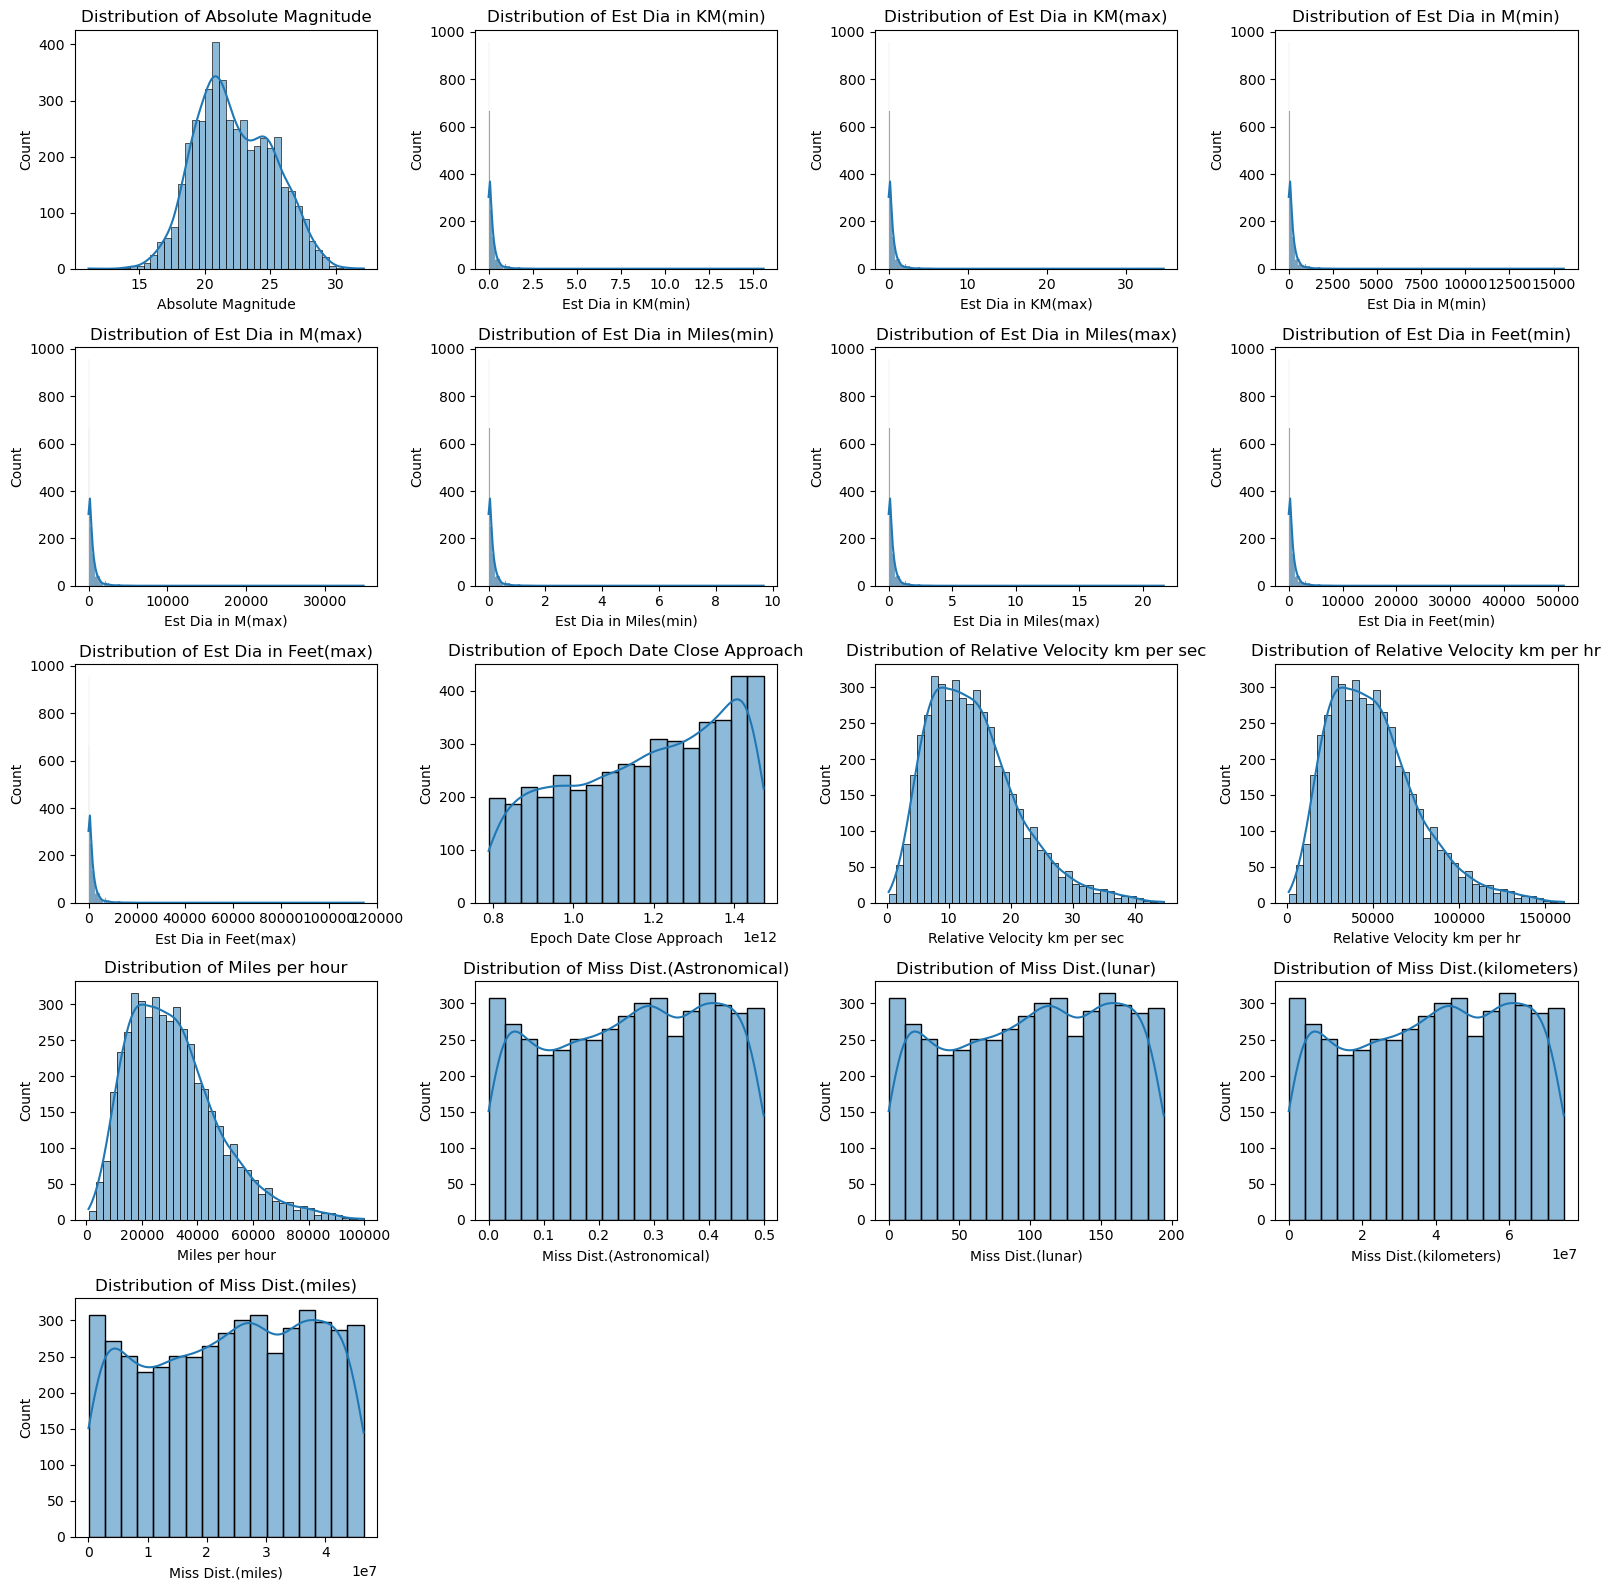

In [31]:

plt.figure(figsize=(16,16))
first_half = len(unclean_df.columns)//2
rows = (first_half +3)//4

for idx, col in enumerate(unclean_df.columns[:first_half]):
  plt.subplot(rows,4, idx+1)
  sns.histplot(unclean_df[col], kde=True)
  plt.title(f"Distribution of {col}")
  plt.tight_layout()
  plt.plot()

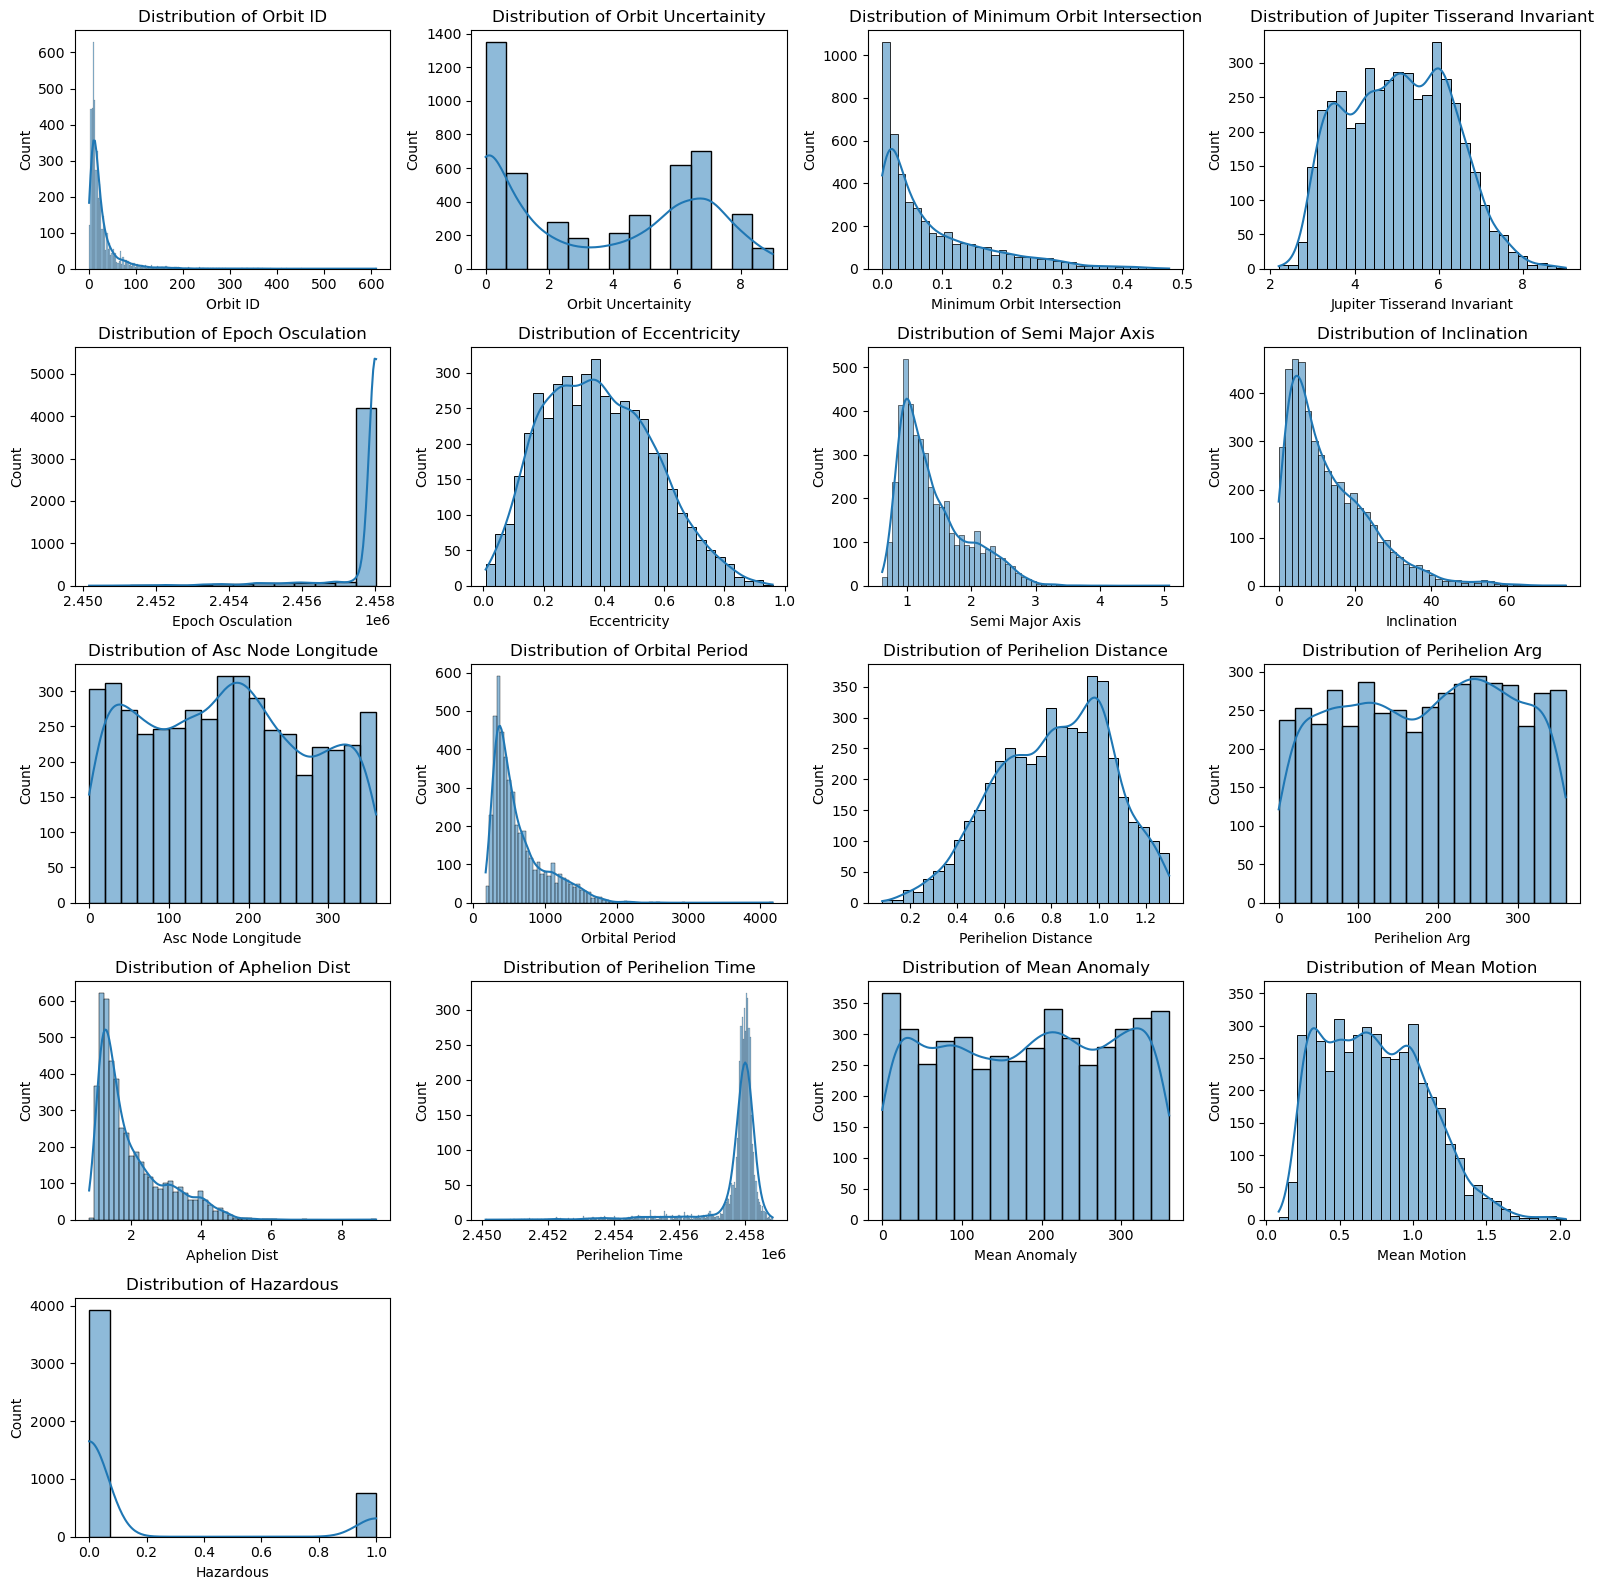

In [32]:
plt.figure(figsize=(16,16))
for idx, col in enumerate(unclean_df.columns[first_half:]):
  plt.subplot(rows,4, idx+1)
  sns.histplot(unclean_df[col], kde=True)
  plt.title(f"Distribution of {col}")
  plt.tight_layout()
  plt.plot()

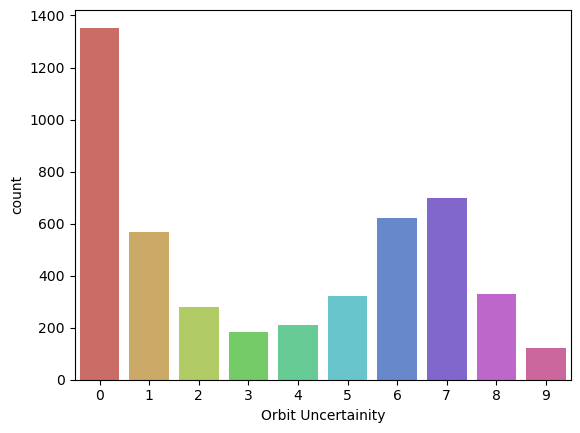

In [38]:
sns.countplot(data=unclean_df, x='Orbit Uncertainity', palette= 'hls')
plt.show()

In [102]:
train_data, validation_data, test_data = np.split(
    model_data.sample(frac=1, random_state=1729),
    [int(0.7 * len(model_data)), int(0.9 * len(model_data))],
)

In [ ]:
rand_split = np.random.rand(len(model_data)) #Generates and array of random numbers uniformly distributed in the range [0 and 1) and the lenght of this array is equal to the lenght of data


# Create a boolean array where each element indicates whether the corresponding element in the rand_split array is less than 0.8. If rand_split[i] < 0.8, then train_list[i] will be True; otherwise, it will be False.
# Here, approximately 80% of the entries (where the condition is True) are designated for training, assuming rand_split was generated from a uniform distribution, as in the previous step
train_list = rand_split < 0.8 

val_list = (rand_split >= 0.8) & (rand_split < 0.9)
test_list = rand_split >= 0.9

data_train = data[train_list] # Use the boolean array train_list to select elements from the data. This operation filters data, keeping only the entries where train_list is True.
data_val = data[val_list]
data_test = data[test_list]

train_y = ((data_train.iloc[:, 1] == "M") + 0).to_numpy() # you want all rows (:) of the second column (1). Casting the True + 0 to become integer  1, and False + 0 becomes 0
train_X = data_train.iloc[:, 2:].to_numpy()

val_y = ((data_val.iloc[:, 1] == "M") + 0).to_numpy()
val_X = data_val.iloc[:, 2:].to_numpy()

test_y = ((data_test.iloc[:, 1] == "M") + 0).to_numpy()
test_X = data_test.iloc[:, 2:].to_numpy();

In [ ]:
# Import time for tuning job name
from time import gmtime, strftime, sleep

# Tuning job name
tuning_job_name = "xgboost-tuningjob2-" + strftime("%d-%H-%M-%S", gmtime())

print(tuning_job_name)

tuning_job_config = {
    "ParameterRanges": {
        "CategoricalParameterRanges": [],
        "ContinuousParameterRanges": [
            {
                "MaxValue": "1",
                "MinValue": "0",
                "Name": "eta",
            },
            {
                "MaxValue": "10",
                "MinValue": "1",
                "Name": "min_child_weight",
            },
            {
                "MaxValue": "2",
                "MinValue": "0",
                "Name": "alpha",
            },
        ],
        "IntegerParameterRanges": [
            {
                "MaxValue": "10",
                "MinValue": "1",
                "Name": "max_depth",
            }
        ]
    },
    "ResourceLimits": {"MaxNumberOfTrainingJobs": 10, "MaxParallelTrainingJobs": 3},
    "Strategy": "Random",
    "HyperParameterTuningJobObjective": {"MetricName": "validation:logloss", "Type": "Minimize"},
}